In [1]:
# ==============================================================================
# 步驟一：資料準備與特徵工程 (最終修正版)
# ==============================================================================
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # 引入 numpy，以備不時之需
import json # 雖然您已有 load_json_map，但此處先引入以備後續可能操作
# --- 中文字體設定 ---
# 請根據您的作業系統和已安裝的字體進行調整
# 方法一：設定全局字體 (macOS/Linux 可能需要指定字體路徑，例如 /System/Library/Fonts/STHeiti Medium.ttc)
# Windows常見： 'Microsoft YaHei', 'SimHei', 'KaiTi'
# macOS常見： 'PingFang HK', 'PingFang SC', 'Heiti TC', 'Arial Unicode MS'
try:
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Microsoft YaHei', 'SimHei', 'PingFang HK', 'Heiti TC'] # 嘗試多個常用中文字體
    plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題
    print("已嘗試設定Matplotlib中文字體。")
except Exception as e:
    print(f"設定Matplotlib中文字體時發生錯誤: {e}")
    print("如果圖表中文顯示為方塊，請確保已安裝中文字體，並正確設定 plt.rcParams['font.sans-serif']。")
    print("例如：plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']") # 台灣用戶可嘗試微軟正黑體
    
# ------------------------------------------------------------------------------
# A. 載入與合併資料
# ------------------------------------------------------------------------------
print(">>> 正在載入資料...")
df_s = pd.read_csv("../data/TIGPSw1_s_descriptive_labeled.csv", low_memory=False)
df_p = pd.read_csv("../data/TIGPSw1_p_descriptive_labeled.csv", low_memory=False)
df_sc = pd.read_csv("../data/TIGPSw1_sc_descriptive_labeled.csv", low_memory=False)

print(">>> 正在合併學生、家長、學校資料...")
df_p_filtered = df_p.drop(columns=['學校 ID'], errors='ignore')
df = pd.merge(df_s, df_p_filtered, on='學生 ID', how='left')
df = pd.merge(df, df_sc, on='學校 ID', how='left')
print(f"合併後的資料維度: {df.shape}")

# ------------------------------------------------------------------------------
# B. 建立核心分析變項 (Feature Engineering)
# ------------------------------------------------------------------------------
print(">>> 正在進行特徵工程，建立分析用變項...")

# --- 通用設定 ---
values_to_replace_nan = ["系統遺漏值", "此卷未答", "我不知道", "跳答", "拒答", "不適用",
                         -9, -8, -7, -6, -4]

# --- 1. 目標變項：學習表現 ---
grade_map = {
    "全班三十名以後": 1, "全班二十一至三十名": 2, "全班十一至二十名": 3,
    "全班六至十名": 4, "全班五名以內": 5
}
df['成績數值'] = df['你上學期的平均成績大約如何?'].replace(values_to_replace_nan, np.nan).map(grade_map)

progress_map = {
    "我落後很多,很難跟得上": 1, "我有點落後,可能跟得上": 2,
    "只落後一點點,很快就跟上了": 3, "大部分都跟得上": 4, "我的進度超前": 5
}
df['學習進度_數值'] = df['你跟得上學校課業進度嗎?'].replace(values_to_replace_nan, np.nan).map(progress_map)

self_reg_map = {"很不符合": 1, "不符合": 2, "符合": 3, "很符合": 4}
df['學習自我管理_專注'] = df['讀書或寫作業時,我會先將無關的網站、即時通訊、手機APP或提醒聲音關掉'].replace(values_to_replace_nan, np.nan).map(self_reg_map)
df['學習自我管理_自制'] = df['我能要求自己先完成作業或讀書進度後,才能去看我喜歡的網站或玩手機。'].replace(values_to_replace_nan, np.nan).map(self_reg_map)
df['學習自我管理分數'] = df[['學習自我管理_專注', '學習自我管理_自制']].mean(axis=1)


# --- 2. 自變項：家庭社經地位 (SES) ---
# 【關鍵修正】直接使用從 JSON 檔案複製的、最準確的文字來定義順序
# 請注意，這裡的「不」是特殊的 Unicode 字元
family_order_corrected = ['很不富裕', '不富裕', '富裕', '很富裕']
final_family_dtype = CategoricalDtype(categories=family_order_corrected, ordered=True)

# 使用修正後的 dtype 進行轉換
df['家境類別'] = df['請問您認為家裡的經濟狀況為何？'].replace(values_to_replace_nan, np.nan).astype(final_family_dtype)
df['家境_數值'] = df['家境類別'].cat.codes

# 驗證修正後的結果
print("\n修正後 '家境類別' 的唯一值:")
print(df['家境類別'].dropna().unique())


# (後續程式碼不變)
education_map = {
    '無／不識字': 1, '自修／識字': 2, '小學': 3, '國（初）中': 4,
    '高中職': 5, '五專、二專': 6, '大學、二技、四技': 7, '碩士': 8, '博士': 9
}
df['家庭教育程度'] = df['請問您的學歷'].replace(values_to_replace_nan, np.nan).map(education_map)

income_map = { '4,999 元以下': 1, '5,000~9,999': 2, '10,000~14,999': 3, '15,000~19,999': 4,
               '20,000~24,999': 5, '25,000~30,999': 6, '30,000~34,999': 7, '35,000~39,999': 8,
               '40,000~44,999': 9, '45,000~49,999': 10, '50,000~59,999': 11, '60,000~69,999': 12,
               '70,000~79,999': 13, '80,000~89,999': 14, '90,000~99,999': 15, '100,000~109,999': 16,
               '110,000~119,999': 17, '120,000~130,999': 18, '130,000~139,999': 19, '140,000~149,999': 20,
               '150,000~199,999': 21, '200,000 元以上': 22 }
df['家長收入_數值'] = df['（薪水、獎金、加班費等都算的話）您這份工作，平均每個月收入大概有多少？'].replace(values_to_replace_nan, np.nan).map(income_map)
df['配偶收入_數值'] = df['（薪水、獎金、加班費等都算的話）您配偶這份工作，平均每個月收入大概有多少？'].replace(values_to_replace_nan, np.nan).map(income_map)
df['家庭總收入'] = df[['家長收入_數值', '配偶收入_數值']].sum(axis=1, min_count=1)

scaler = StandardScaler()
df_ses_clean = df[['家境_數值', '家庭教育程度', '家庭總收入']].dropna()
ses_scaled = scaler.fit_transform(df_ses_clean)
df.loc[df_ses_clean.index, 'SES_綜合分數'] = ses_scaled.sum(axis=1)


# --- 3. 中介變項：數位資源與使用模式 ---
internet_quality_map = {"經常": 1, "有時": 2, "偶爾": 3, "從未": 5}
df['網路品質_數值'] = df['我住的地方沒有網路訊號或是訊號太弱。'].replace(values_to_replace_nan, np.nan).map(internet_quality_map)

def get_network_stability(row):
    if row['(2)固網寬頻（ADSL 512K 以上、Cable Modem、光纖）'] == '有': return 3
    elif row['(4)手機 4G（或 5G）訊號分享'] == '有': return 2
    elif row['(7)家中無法上網'] == '有': return 1
    return np.nan
df['網路穩定度'] = df[['(2)固網寬頻（ADSL 512K 以上、Cable Modem、光纖）', '(4)手機 4G（或 5G）訊號分享', '(7)家中無法上網']].apply(get_network_stability, axis=1)

device_cols = ['桌上型電腦_______台', '筆記型電腦_______台', '平板電腦_______台']
for col in device_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df['家中設備總數'] = df[device_cols].sum(axis=1)

time_mapping = {
    "沒有": 0.0, "0.5小時以內": 0.25, "0.5-1小時": 0.75, "1-1.5小時": 1.25,
    "1.5-2小時": 1.75, "2-2.5小時": 2.25, "2.5-3小時": 2.75, "3-3.5小時": 3.25,
    "3.5-4小時": 3.75, "4-4.5小時": 4.25, "4.5-5小時": 4.75, "5小時以上": 5.5
}
time_cols = [
    "完成學校功課(查找完成作業需要的資料)", "課外的學習(各種線上付費或免費的課程)",
    "玩線上遊戲", "看影片、聽音樂、迷因梗圖、卡通、漫畫", "和他人聊天(傳訊息)"
]
for col in time_cols:
    df[col + "_num"] = df[col].replace(values_to_replace_nan, np.nan).map(time_mapping)

df['total_time'] = df[[c + "_num" for c in time_cols]].sum(axis=1)
df['study_ratio'] = (df["完成學校功課(查找完成作業需要的資料)_num"] + df["課外的學習(各種線上付費或免費的課程)_num"]) / df['total_time'].replace(0, np.nan)

freq_map = {'沒有這項設備': 0, '幾乎沒有': 1, '一年幾次': 2, '每月一兩次': 3, '每月三四次': 4,
            '每週一兩次': 5, '每週三四次': 6, '幾乎每天': 7}
df['電腦使用頻率'] = df['電腦(含桌機或筆電)'].replace(values_to_replace_nan, np.nan).map(freq_map)
df['手機使用頻率'] = df['智慧型手機'].replace(values_to_replace_nan, np.nan).map(freq_map)


# --- 4. 調節變項：學校支持 ---
support_map = {"很不符合": 1, "不符合": 2, "符合": 3, "很符合": 4}
support_cols = [
    '除臺灣學術網路外,本校另行付費提升頻寬',
    '本校固定購置/導入支持課室數位互動的硬體設備(如大螢幕、短焦投影、Smartboard等)',
    '本校的資訊設備借用與管理機制運作完善',
    '本校能獲得推動數位學習充分的人事或業務費支持',
    '本校能獲得推動數位學習充分的設備費支持'
]
for col in support_cols:
    df[col + '_數值'] = df[col].replace(values_to_replace_nan, np.nan).map(support_map)

numeric_support_cols = [col + '_數值' for col in support_cols]
df['學校支持_綜合分數'] = df[numeric_support_cols].mean(axis=1)

support_median = df['學校支持_綜合分數'].median()
df['support_group'] = df['學校支持_綜合分數'].apply(lambda x: '高支持' if x >= support_median else '低支持' if pd.notna(x) else np.nan)


# ------------------------------------------------------------------------------
# C. 建立最終分析資料集
# ------------------------------------------------------------------------------
print(">>> 正在生成最終分析用的 DataFrame...")
analysis_cols = [
    '家境類別', '家境_數值', '家庭教育程度', '家庭總收入', 'SES_綜合分數',
    '網路品質_數值', '網路穩定度', '家中設備總數', 'study_ratio', '電腦使用頻率', '手機使用頻率',
    '成績數值', '學習進度_數值', '學習自我管理分數',
    'support_group', '學校支持_綜合分數',
    '請問您認為家裡的經濟狀況為何？',
    '我住的地方沒有網路訊號或是訊號太弱。',
    '你上學期的平均成績大約如何?'
]

existing_cols = [col for col in analysis_cols if col in df.columns]
df_analysis = df[existing_cols].copy()


# ------------------------------------------------------------------------------
# D. 檢視成果
# ------------------------------------------------------------------------------
print("\n--- 分析用資料集 df_analysis 資訊 ---")
df_analysis.info()

已嘗試設定Matplotlib中文字體。
>>> 正在載入資料...
>>> 正在合併學生、家長、學校資料...
合併後的資料維度: (10008, 1386)
>>> 正在進行特徵工程，建立分析用變項...

修正後 '家境類別' 的唯一值:
['不富裕', '富裕', '很不富裕', '很富裕']
Categories (4, object): ['很不富裕' < '不富裕' < '富裕' < '很富裕']
>>> 正在生成最終分析用的 DataFrame...

--- 分析用資料集 df_analysis 資訊 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10008 entries, 0 to 10007
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   家境類別                4190 non-null   category
 1   家境_數值               10008 non-null  int8    
 2   家庭教育程度              4333 non-null   float64 
 3   家庭總收入               3615 non-null   float64 
 4   SES_綜合分數            3611 non-null   float64 
 5   網路品質_數值             5234 non-null   float64 
 6   網路穩定度               2317 non-null   float64 
 7   家中設備總數              10008 non-null  float64 
 8   study_ratio         4570 non-null   float64 
 9   電腦使用頻率              5252 non-null   float64 
 10  手機使用頻率             

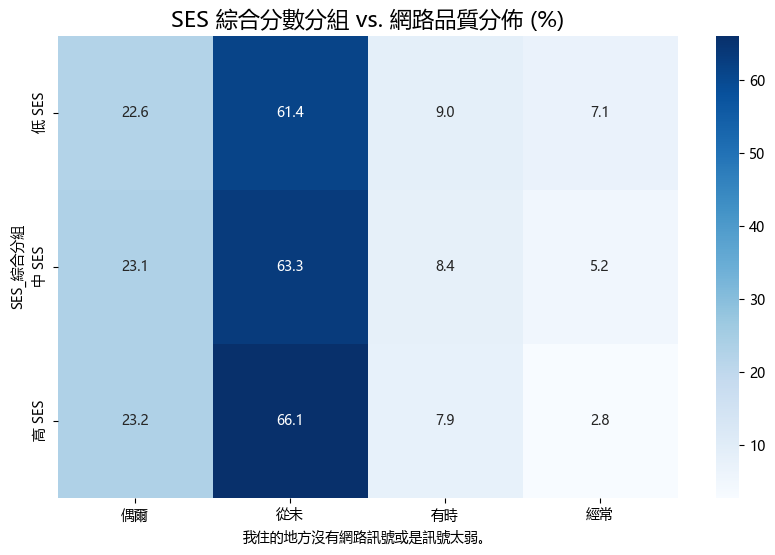

【使用 SES 綜合分數】卡方檢定 p-value: 0.0366
>> 結論：SES 綜合分數與網路品質存在顯著關聯。


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 準備工作：將 SES 綜合分數分組 ---
# 使用 qcut 可以將資料按數量大致均等地分成三組
df_analysis['SES_綜合分組'] = pd.qcut(df_analysis['SES_綜合分數'], q=3, labels=['低 SES', '中 SES', '高 SES'], duplicates='drop')

# --- 製作交叉表並視覺化 ---
# 確保原始的網路品質文字欄位存在
# 欄位名: '我住的地方沒有網路訊號或是訊號太弱。'
contingency_ses_score = pd.crosstab(
    df_analysis['SES_綜合分組'],
    df_analysis['我住的地方沒有網路訊號或是訊號太弱。'].replace(values_to_replace_nan, np.nan).dropna()
)
# 正規化，計算百分比
contingency_percent_ses_score = contingency_ses_score.div(contingency_ses_score.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(contingency_percent_ses_score, annot=True, cmap="Blues", fmt='.1f')
plt.title('SES 綜合分數分組 vs. 網路品質分佈 (%)', fontsize=16)
plt.show()

# --- 統計檢定 ---
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(contingency_ses_score)
print(f"【使用 SES 綜合分數】卡方檢定 p-value: {p:.4f}")
if p < 0.05:
    print(">> 結論：SES 綜合分數與網路品質存在顯著關聯。")
else:
    print(">> 結論：未發現 SES 綜合分數與網路品質之間存在顯著關聯。")

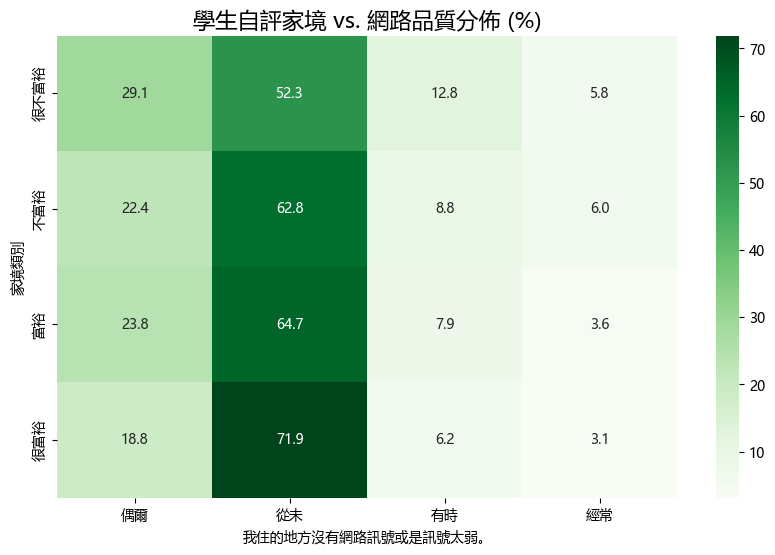

【使用學生自評家境】卡方檢定 p-value: 0.1245
>> 結論：未發現學生自評家境與網路品質之間存在顯著關聯。


In [3]:
# --- 製作交叉表並視覺化 ---
contingency_student_report = pd.crosstab(
    df_analysis['家境類別'],
    df_analysis['我住的地方沒有網路訊號或是訊號太弱。'].replace(values_to_replace_nan, np.nan).dropna()
)
contingency_percent_student = contingency_student_report.div(contingency_student_report.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(contingency_percent_student, annot=True, cmap="Greens", fmt='.1f')
plt.title('學生自評家境 vs. 網路品質分佈 (%)', fontsize=16)
plt.show()

# --- 統計檢定 ---
chi2, p, dof, expected = chi2_contingency(contingency_student_report)
print(f"【使用學生自評家境】卡方檢定 p-value: {p:.4f}")
if p < 0.05:
    print(">> 結論：學生自評家境與網路品質存在顯著關聯。")
else:
    print(">> 結論：未發現學生自評家境與網路品質之間存在顯著關聯。")

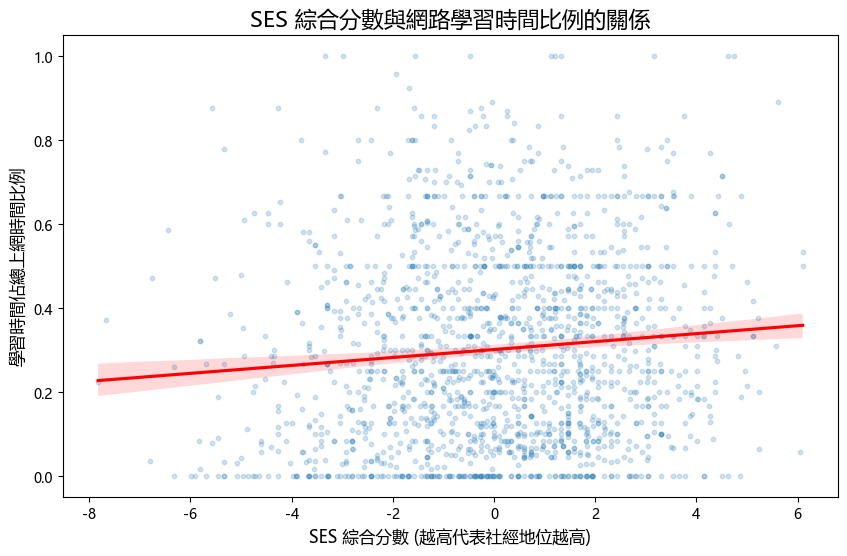

【使用 SES 綜合分數】Spearman 相關係數 ρ = 0.0947, p-value = 0.0001


In [4]:
from scipy.stats import spearmanr

# --- 視覺化 ---
plt.figure(figsize=(10, 6))
# regplot 可以同時畫出散佈圖和回歸線
sns.regplot(data=df_analysis, x='SES_綜合分數', y='study_ratio', 
            scatter_kws={'alpha':0.2, 's':10}, line_kws={'color': 'red'})
plt.title('SES 綜合分數與網路學習時間比例的關係', fontsize=16)
plt.xlabel('SES 綜合分數 (越高代表社經地位越高)', fontsize=12)
plt.ylabel('學習時間佔總上網時間比例', fontsize=12)
plt.show()

# --- 統計檢定 ---
# 移除包含 NaN 的行再計算相關性
temp_df = df_analysis[['SES_綜合分數', 'study_ratio']].dropna()
rho, p = spearmanr(temp_df['SES_綜合分數'], temp_df['study_ratio'])
print(f"【使用 SES 綜合分數】Spearman 相關係數 ρ = {rho:.4f}, p-value = {p:.4f}")

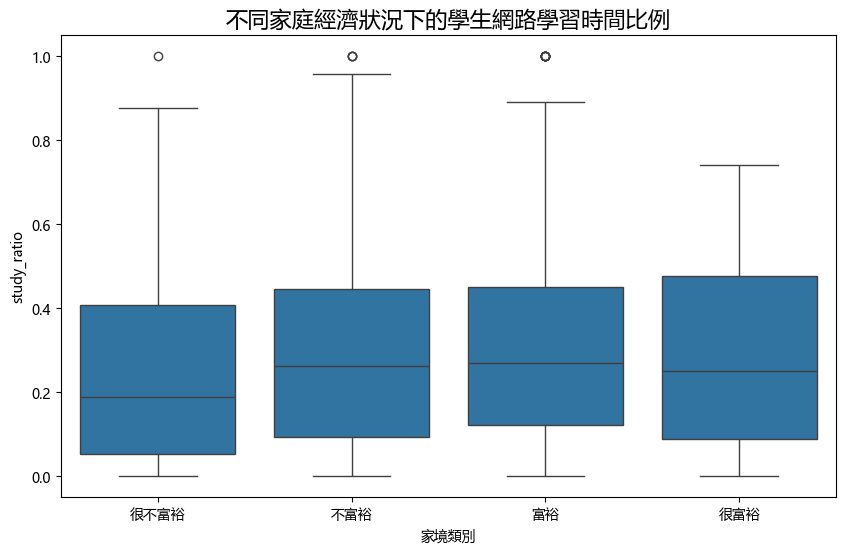

【使用學生自評家境】Kruskal-Wallis 檢定 p-value: 0.0981
>> 結論：不同家庭經濟狀況的學生，其學習時間比例無顯著差異。


In [5]:
from scipy.stats import kruskal

# --- 視覺化 ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_analysis, x='家境類別', y='study_ratio', order=family_order_corrected)
plt.title('不同家庭經濟狀況下的學生網路學習時間比例', fontsize=16)
plt.show()

# --- 統計檢定 ---
data_for_test = df_analysis.dropna(subset=['家境類別', 'study_ratio'])
groups = [group['study_ratio'].values for name, group in data_for_test.groupby('家境類別', observed=True)]
if len(groups) > 1:
    h_stat, p_val = kruskal(*groups)
    print(f"【使用學生自評家境】Kruskal-Wallis 檢定 p-value: {p_val:.4f}")
    if p_val < 0.05:
        print(">> 結論：不同家庭經濟狀況的學生，其學習時間比例有顯著差異。")
    else:
        print(">> 結論：不同家庭經濟狀況的學生，其學習時間比例無顯著差異。")

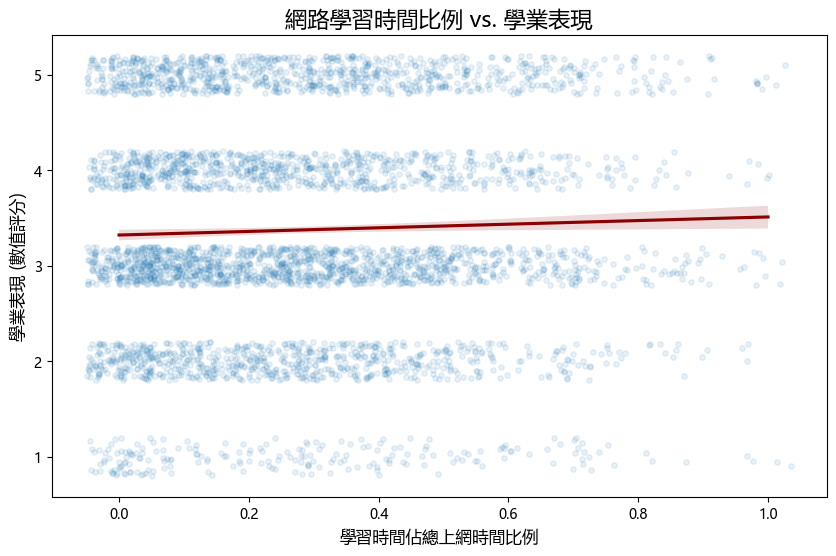

【使用模式】學習時間比例 vs. 學業表現的 Spearman 相關係數：
ρ = 0.0378, p-value = 0.0146
>> 結論：兩者存在統計上的顯著關聯，但 ρ值為 0.0378，表示關聯性非常微弱。


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# --- 視覺化 ---
plt.figure(figsize=(10, 6))
# 使用 jitter 增加少量隨機噪點，避免點過度重疊
sns.regplot(data=df_analysis, x='study_ratio', y='成績數值', 
            x_jitter=0.05, y_jitter=0.2,
            scatter_kws={'alpha':0.1, 's':15}, 
            line_kws={'color': 'darkred'})
plt.title('網路學習時間比例 vs. 學業表現', fontsize=16)
plt.xlabel('學習時間佔總上網時間比例', fontsize=12)
plt.ylabel('學業表現 (數值評分)', fontsize=12)
plt.show()

# --- 統計檢定 ---
temp_df_study = df_analysis[['study_ratio', '成績數值']].dropna()
rho_study, p_study = spearmanr(temp_df_study['study_ratio'], temp_df_study['成績數值'])

print(f"【使用模式】學習時間比例 vs. 學業表現的 Spearman 相關係數：")
print(f"ρ = {rho_study:.4f}, p-value = {p_study:.4f}")
if p_study < 0.05:
    print(f">> 結論：兩者存在統計上的顯著關聯，但 ρ值為 {rho_study:.4f}，表示關聯性非常微弱。")
else:
    print(">> 結論：未發現學習時間比例與學業表現之間存在顯著的單調關聯。")

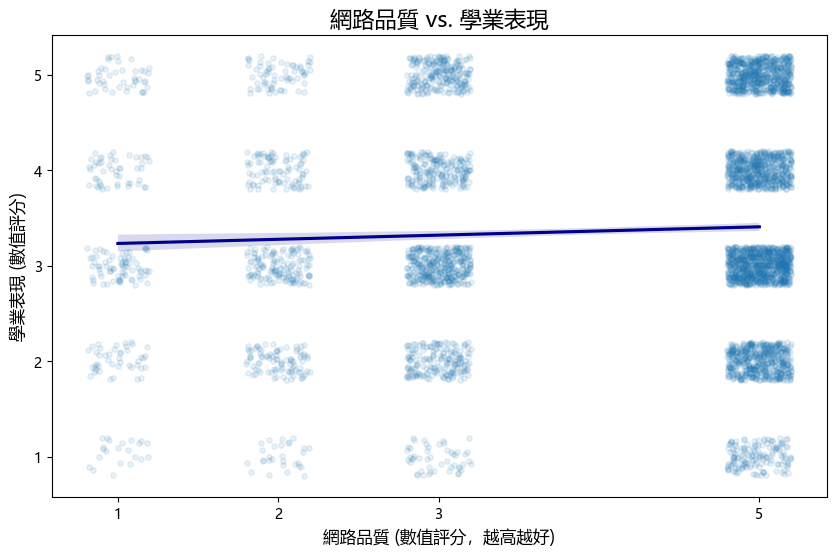

【資源品質】網路品質 vs. 學業表現的 Spearman 相關係數：
ρ = 0.0446, p-value = 0.0021
>> 結論：兩者存在統計上的顯著關聯，但 ρ值為 0.0446，表示關聯性非常微弱。


In [7]:
# --- 視覺化 ---
plt.figure(figsize=(10, 6))
# 由於網路品質數值是離散的，jitter 特別重要
sns.regplot(data=df_analysis, x='網路品質_數值', y='成績數值',
            x_jitter=0.2, y_jitter=0.2, # x軸給予較大的擾動以便觀察
            scatter_kws={'alpha':0.1, 's':15}, 
            line_kws={'color': 'darkblue'})
plt.title('網路品質 vs. 學業表現', fontsize=16)
plt.xlabel('網路品質 (數值評分，越高越好)', fontsize=12)
plt.ylabel('學業表現 (數值評分)', fontsize=12)
# 讓 x 軸的刻度更清晰
plt.xticks(ticks=sorted(df_analysis['網路品質_數值'].dropna().unique()))
plt.show()

# --- 統計檢定 ---
temp_df_quality = df_analysis[['網路品質_數值', '成績數值']].dropna()
rho_quality, p_quality = spearmanr(temp_df_quality['網路品質_數值'], temp_df_quality['成績數值'])

print(f"【資源品質】網路品質 vs. 學業表現的 Spearman 相關係數：")
print(f"ρ = {rho_quality:.4f}, p-value = {p_quality:.4f}")
if p_quality < 0.05:
    print(f">> 結論：兩者存在統計上的顯著關聯，但 ρ值為 {rho_quality:.4f}，表示關聯性非常微弱。")
else:
    print(">> 結論：未發現網路品質與學業表現之間存在顯著的單調關聯。")

>>> 正在繪製調節效應探索圖...


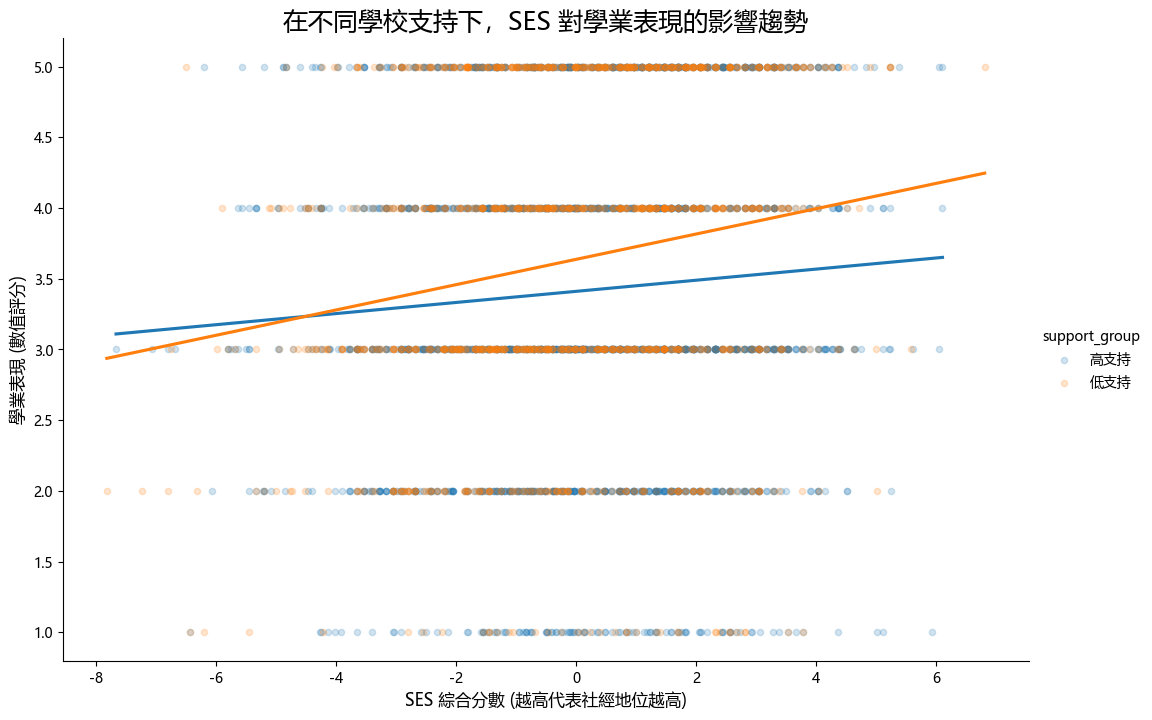

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- 視覺化探索調節效應 ---
print(">>> 正在繪製調節效應探索圖...")

# 使用 lmplot 可以輕鬆地按組別（hue）繪製不同的回歸趨勢線
lm = sns.lmplot(
    data=df_analysis.dropna(subset=['SES_綜合分數', '成績數值', 'support_group']),
    x='SES_綜合分數',
    y='成績數值',
    hue='support_group',  # 關鍵：用 support_group 來區分顏色和趨勢線
    ci=None,              # 關閉信賴區間，讓圖更簡潔
    height=7,
    aspect=1.5,
    scatter_kws={'alpha': 0.2, 's': 20} # 讓散點更清晰
)

# 設定圖表標題和軸標籤
lm.ax.set_title('在不同學校支持下，SES 對學業表現的影響趨勢', fontsize=18)
lm.set_xlabels('SES 綜合分數 (越高代表社經地位越高)', fontsize=12)
lm.set_ylabels('學業表現 (數值評分)', fontsize=12)

plt.show()

In [9]:
from scipy.stats import spearmanr

print("\n--- 調節作用統計檢定 ---")

# 使用我們之前建立的 SES_綜合分數 和 support_group
for group_name in ['高支持', '低支持']:
    # 篩選出特定組別的資料，並移除相關欄位的缺失值
    subset = df_analysis[df_analysis['support_group'] == group_name].dropna(subset=['SES_綜合分數', '成績數值'])
    
    # 檢查資料是否足夠且有變異，避免出現錯誤
    if len(subset) < 5 or subset['SES_綜合分數'].nunique() < 2 or subset['成績數值'].nunique() < 2:
        print(f"\n在「{group_name}」學校中：數據不足或缺乏變異，無法計算相關性。")
        continue
        
    # 計算相關性
    rho, p = spearmanr(subset['SES_綜合分數'], subset['成績數值'])
    
    print(f"\n在「{group_name}」學校中，SES 與學業表現的 Spearman 相關性：")
    print(f"樣本數 (N) = {len(subset)}")
    print(f"相關係數 ρ = {rho:.4f}")
    print(f"p-value = {p:.4f}")
    
    if p < 0.05:
        print(">> 關聯達到統計顯著性。")
    else:
        print(">> 關聯未達到統計顯著性。")


--- 調節作用統計檢定 ---

在「高支持」學校中，SES 與學業表現的 Spearman 相關性：
樣本數 (N) = 2154
相關係數 ρ = 0.0767
p-value = 0.0004
>> 關聯達到統計顯著性。

在「低支持」學校中，SES 與學業表現的 Spearman 相關性：
樣本數 (N) = 1167
相關係數 ρ = 0.1721
p-value = 0.0000
>> 關聯達到統計顯著性。
